In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv(r'final_cleaned_preproecessed_file.csv')

In [3]:
overview = data.loc[:, ['id','overview']]
data = data.drop(['id', 'overview', 'IMDB Score','revenue', 'vote_average', 'vote_count','production_company_2','popularity','num_faces', 'brightness',
       'saturation', 'hue', 'brightness_sd', 'saturation_sd ', 'hue_sd',
       'blue', 'blue_sd', 'green', 'green_sd', 'red', 'red_sd ',], axis = 1)

###   Missing Values

In [4]:
data[data.budget == 0].shape

(4637, 29)

In [5]:
data[data.runtime == 0].shape

(131, 29)

In [6]:
data[data.Lead_Actor == '0'].shape

(521, 29)

In [7]:
data[data.Supporting_Actor == '0'].shape

(392, 29)

In [8]:
data[data.Director == '0'].shape

(56, 29)

In [9]:
data[data.Producer == '0'].shape

(2506, 29)

### Imputing values for Numerical Variable - runtime

In [10]:
imputer_runtime = SimpleImputer(missing_values=0, strategy = 'mean')

data.loc[:,['runtime']] = imputer_runtime.fit_transform(data.loc[:,['runtime']])

with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('imputer_runtime'), "wb") as f:   
    pickle.dump(imputer_runtime, f)

### Imputing values for Categorical Variables - 
'production_company_1', 'production_company_2', 'Lead_Actor', 'Supporting_Actor', 'Director',
       'Producer'

In [11]:
imputer_categorical = SimpleImputer(missing_values='0', strategy='most_frequent')
cols = ['production_company_1', 'Lead_Actor', 'Supporting_Actor', 'Director','Producer']
data.loc[:,cols] =imputer_categorical.fit_transform(data.loc[:,cols])

### Categorical encoding - Target Encoding

In [12]:
import category_encoders as ce
from category_encoders import TargetEncoder

encoder_lead_actor = ce.TargetEncoder(cols= 'Lead_Actor') 
data.loc[:,'Lead_Actor'] = encoder_lead_actor.fit_transform(data['Lead_Actor'],data['rating'])
with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('encoder_lead_actor'), "wb") as f:   
    pickle.dump(encoder_lead_actor, f)

encoder_sup_actor = ce.TargetEncoder(cols= 'Supporting_Actor') 
data.loc[:,'Supporting_Actor'] = encoder_sup_actor.fit_transform(data['Supporting_Actor'],data['rating'])
with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('encoder_sup_actor'), "wb") as f:   
    pickle.dump(encoder_sup_actor, f)
    
encoder_director_name = ce.TargetEncoder(cols= 'Director') 
data.loc[:,'Director'] = encoder_director_name.fit_transform(data['Director'],data['rating'])
with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('encoder_director_name'), "wb") as f:   
    pickle.dump(encoder_director_name, f)
    
encoder_producer_name = ce.TargetEncoder(cols= 'Producer') 
data.loc[:,'Producer'] = encoder_producer_name.fit_transform(data['Producer'],data['rating'])
with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('encoder_producer_name'), "wb") as f:   
    pickle.dump(encoder_producer_name, f)
    
encoder_production_company_1 = ce.TargetEncoder(cols= 'production_company_1') 
data.loc[:,'production_company_1'] = encoder_production_company_1.fit_transform(data['production_company_1'],data['rating'])
with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('encoder_production_company_1'), "wb") as f:   
    pickle.dump(encoder_production_company_1, f)

### Imputing values for budget using KNN

In [13]:
train = data[data['budget'] != 0].copy()
test = data[data['budget'] == 0].copy()
X_train, X_test, y_train, y_test =  train.drop('budget',axis = 1), test.drop('budget',axis = 1), train.loc[:,'budget'], test.loc[:,'budget']
ind = y_test.index

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

for i in range(ind.shape[0]):
    data.loc[ind[i],'budget'] = y_pred[i]
    

In [14]:
print('-------------| Order of selected columns in data |-------------')
for i,j in enumerate(data.columns) :
    print('               {} : {}'.format(i,j))
    

-------------| Order of selected columns in data |-------------
               0 : belongs_to_collection
               1 : budget
               2 : runtime
               3 : Action
               4 : Adventure
               5 : Animation
               6 : Comedy
               7 : Crime
               8 : Documentary
               9 : Drama
               10 : Family
               11 : Fantasy
               12 : Foreign
               13 : History
               14 : Horror
               15 : Music
               16 : Mystery
               17 : Romance
               18 : Science Fiction
               19 : TV Movie
               20 : Thriller
               21 : War
               22 : Western
               23 : production_company_1
               24 : Lead_Actor
               25 : Supporting_Actor
               26 : Director
               27 : Producer
               28 : rating


### Bag of Words Model with CountVectorizer

In [15]:
import re
import nltk
import pickle
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
def preprocess(df, lst) : 
    for i in range(df.shape[0]) :
        comment = re.sub(r'[?|!|\'|"|#]',r'', df['overview'][i])
        comment = re.sub(r'[.|,|)|(|\|/]',r' ', comment)
        comment = comment.replace("\n"," ")
        comment = re.sub('[^a-zA-Z]',' ', comment)
        comment = comment.lower()
        comment = comment.split()
        ps = SnowballStemmer(language='english')
        comment = [ps.stem(word) for word in comment if not word in set(stopwords.words('english'))]
        comment = ' '.join(comment)
        lst.append(comment)
        if i%1000 == 0 :
            print(str(i) +' overviews processed')

    
start1 = datetime.now()    
corpus = []
preprocess(overview, corpus)
end1 = datetime.now()
print('\n---------| Corpus created |----------')
print('\n---------| Time taken to create corpus : |----------', start1 - end1)

cv = CountVectorizer(max_features=500)

ovrvw = cv.fit_transform(corpus).toarray()

with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('vectorizer'), "wb") as f:   
    pickle.dump(cv, f)

pd.DataFrame(ovrvw).to_csv('overview_cv.csv',index_label = False)


ovrvw = pd.read_csv(r'overview_cv.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ANP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0 overviews processed
1000 overviews processed
2000 overviews processed
3000 overviews processed
4000 overviews processed
5000 overviews processed
6000 overviews processed

---------| Corpus created |----------

---------| Time taken to create corpus : |---------- -1 day, 23:57:41.014437


In [16]:
y = data.loc[:,'rating'].values
X = data.loc[:,:'rating'].values
print('-------------| X Shape : {} |-------------'.format(X.shape))

-------------| X Shape : (6634, 29) |-------------


### Concatinating vectors of overview data with the rest of the data

In [17]:
X = np.hstack((X,ovrvw))

### Scaling Data

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X = sc.fit_transform(X)

with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('standard_scaler'), "wb") as f:   
    pickle.dump(sc, f)

### Splitting data into train set (90%) and test set (10%)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Fitting Ridge Regression model to train set with Grid Search

In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

start = datetime.now()

param = {'alpha' : np.linspace(0.0001, 1, 50)}

grids = GridSearchCV(Ridge(), param_grid = param, cv = 10,scoring = 'neg_mean_absolute_error', n_jobs = -1)

grids.fit(X_train,y_train)

end = datetime.now()

print('-------------| Time to fit the model : {} |-------------'.format(start - end))

print('-------------| Best Paramters : {} |-------------'.format(grids.best_params_))

-------------| Time to fit the model : -1 day, 23:59:09.900746 |-------------
-------------| Best Paramters : {'alpha': 0.0001} |-------------


In [21]:
print('-------------| Mean Absolute Error on Train set : {} |-------------'.format(-1*grids.best_score_))

-------------| Mean Absolute Error on Train set : 1.2403106155255467e-08 |-------------


In [22]:
y_test_pred = grids.predict(X_test)

from sklearn.metrics import mean_absolute_error

print('-------------| Mean Absolute Error on Test set : {} |-------------'.format(mean_absolute_error(y_test, y_test_pred)))

-------------| Mean Absolute Error on Test set : 1.1082173490296704e-08 |-------------


In [23]:
print('-------------| For parameter alpha = {} |-------------'.format(grids.best_params_['alpha']))

model = Ridge(alpha = grids.best_params_['alpha'])

model.fit(X_train, y_train)

with open(r"F:\Projects\Internship\Technocolabs\movie_ratings\pickle\{}.pkl".format('final_model'), "wb") as f:   
    pickle.dump(model, f)

-------------| For parameter alpha = 0.0001 |-------------


### Feature Importance

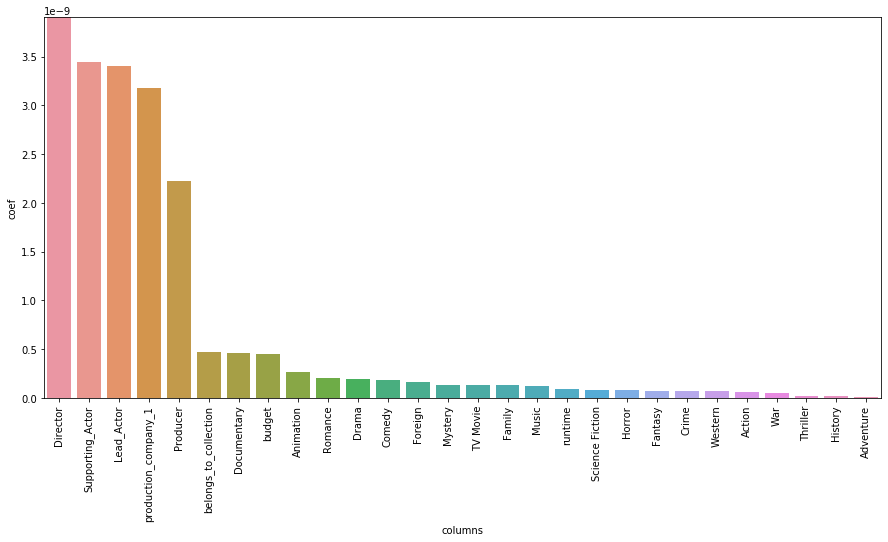

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15,7))
temp = pd.DataFrame({'columns' : data.columns[:-1], 'coef' :abs(model.coef_[:28])})
temp1 = temp.sort_values('coef',ascending = False)
sns.barplot(temp1['columns'],temp1['coef'])
plt.xticks(rotation=90)
plt.show()

### Important genres for ratings

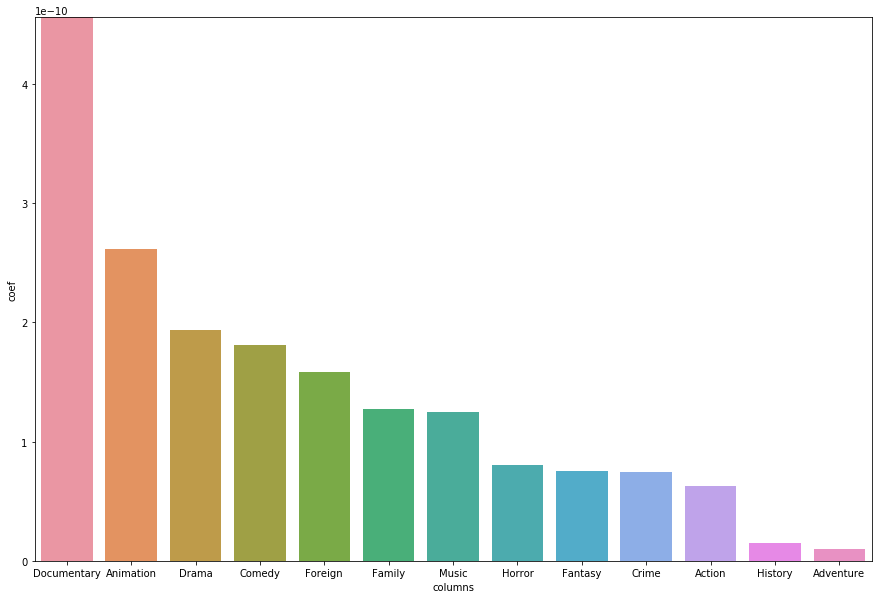

In [25]:
temp2 = temp[3:16].sort_values('coef', ascending = False)
plt.figure(figsize = (15,10))
sns.barplot(temp2['columns'],temp2['coef'])
plt.show()